In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
from sklearn.metrics import mean_squared_error

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd
import time
from sklearn.metrics import r2_score
import rrcf

C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\HakkyuKim\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def score_for_res(pred, trueval) :
    u2 = (pred-trueval)**2
    v2 = (trueval-trueval.mean())**2
    
    return 1-(u2.sum()/v2.sum())

In [3]:
def partial_train(mtr, X_test, y_test):
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    mtr.partial_fit(X_test, y_test)
    #print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))
    return y_pred, y_std

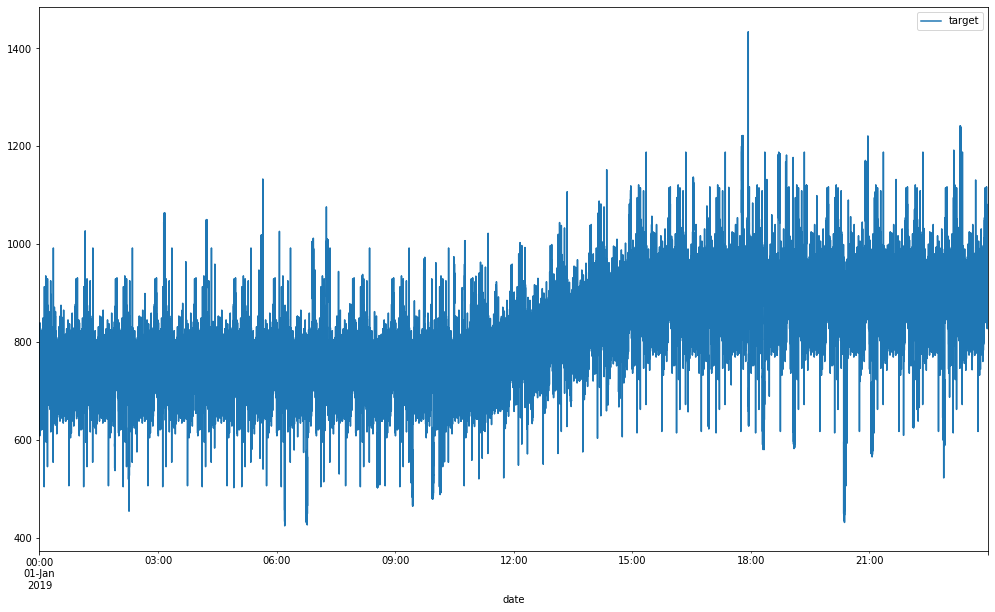

In [4]:
network = pd.read_csv('C:/Users/HakkyuKim/Desktop/yeonwoo/Starter_pack/Starter_pack/Code/Python/initial_training_data.csv', index_col='date', parse_dates=['date'])
network.head()

rcParams['figure.figsize'] = 17,10
network.describe()
network.plot()

In [5]:
network.describe()

,target
count,86400.000000
mean,808.433553
std,97.663811
min,424.000000
25%,735.000000
50%,801.000000
75%,881.000000
max,1434.000000


In [6]:
#construct forest of empty RCTrees

num_trees = 40
shingle_size = 60
tree_size = 256


forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

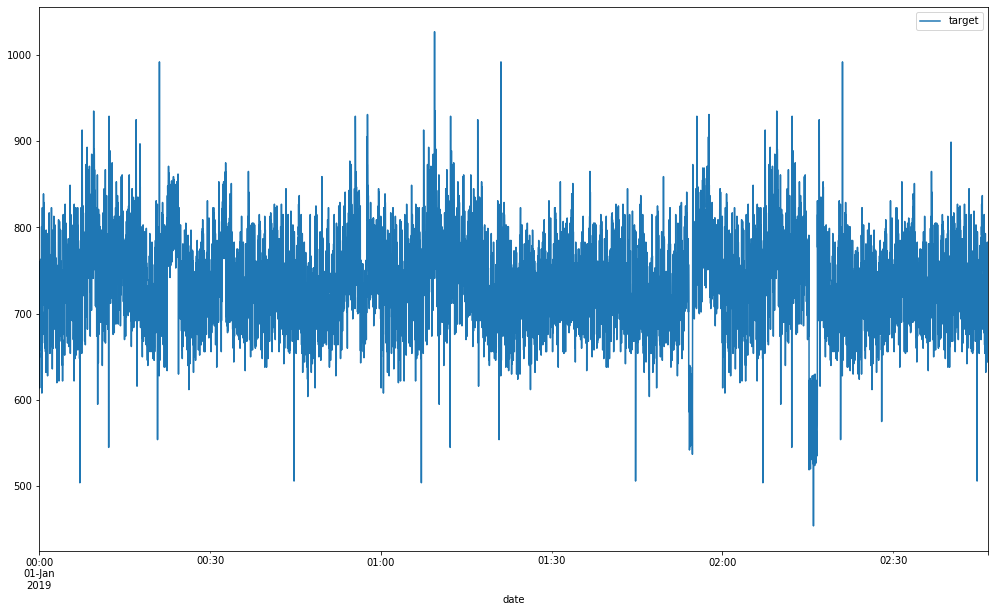

In [7]:
#train data 정제
ntw_clean = network.copy()

train_len = 10000
ntw_clean = ntw_clean[:train_len]

avg_codisp = {}
train_mean = ntw_clean.mean()

ntw_clean.plot()

In [8]:
for index in range(0, train_len) :
    point = ntw_clean[index:index+1] #get one by one
    
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        
        ntw_clean.iloc[index] = train_mean
        


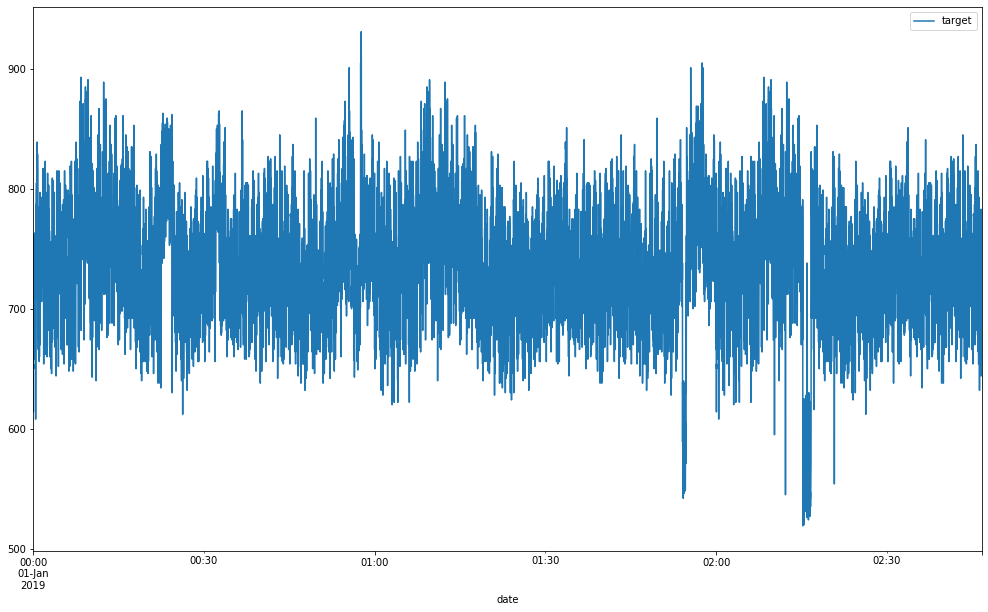

In [9]:

ntw_clean.plot()


In [10]:
avg_codisp

{0: 0.0,
 1: 1.0000000000000004,
 2: 1.0000000000000004,
 3: 2.2999999999999994,
 4: 1.2999999999999998,
 5: 1.2249999999999999,
 6: 1.3374999999999995,
 7: 2.8499999999999996,
 8: 4.6625000000000005,
 9: 2.8625000000000003,
 10: 1.25,
 11: 3.6458333333333353,
 12: 3.0458333333333325,
 13: 2.129166666666666,
 14: 4.043750000000001,
 15: 1.824999999999999,
 16: 2.0791666666666666,
 17: 2.0675000000000003,
 18: 3.5637499999999984,
 19: 2.660416666666667,
 20: 3.094583333333333,
 21: 3.042261904761904,
 22: 2.405059523809524,
 23: 2.8226984126984127,
 24: 13.183333333333328,
 25: 2.4974999999999996,
 26: 2.757746212121212,
 27: 7.765833333333336,
 28: 1.5383333333333336,
 29: 1.8175,
 30: 2.254065656565656,
 31: 7.975178571428573,
 32: 12.001041666666664,
 33: 3.2168589743589746,
 34: 2.15875,
 35: 3.187925824175824,
 36: 6.083829365079361,
 37: 4.30375,
 38: 3.920236742424243,
 39: 2.217321428571429,
 40: 1.9210789557664563,
 41: 5.725303030303031,
 42: 3.5375068681318687,
 43: 2.2373511

In [11]:
#train set만들기
tmp = ntw_clean.shift(1)
tmp2 = ntw_clean.shift(2)
tmp3 = ntw_clean.shift(3)

ntw_prev = ntw_clean.copy()
ntw_prev['prev1'] = tmp['target']
ntw_prev['prev2'] = tmp2['target']
ntw_prev['prev3'] = tmp3['target']

ntw_prev = ntw_prev[4:]
ntw_prev.tail()

,target,prev1,prev2,prev3
date,,,,
2019-01-01 02:46:35,644.0,652.0,783.0,723.0
2019-01-01 02:46:36,728.0,644.0,652.0,783.0
2019-01-01 02:46:37,652.0,728.0,644.0,652.0
2019-01-01 02:46:38,714.0,652.0,728.0,644.0
2019-01-01 02:46:39,717.0,714.0,652.0,728.0


In [12]:


#training은 clean한 data로, test는 clean하지 않은 data를 rrcf로 다시 정제하면서 진행할거임



#xt = [network[10000:10001], network.iloc[10001], network.iloc[10002]]
xt = pd.Series()


In [13]:
type(xt)
print(xt)

Series([], dtype: float64)


In [14]:
mfr = MondrianForestRegressor(random_state = 1, n_estimators=100, bootstrap=True)
for i in range(3, len(ntw_clean)):
    X_train = pd.Series()
    X_train['prev1'] = ntw_clean[i-3:i-2]['target']
    X_train['prev2'] = ntw_clean[i-2:i-1]['target']
    X_train['prev3'] = ntw_clean[i-1:i]['target']
    y_train = ntw_clean[i:i+1]['target']
    mfr.partial_fit(X_train.values.reshape(1, -1), y_train)

prediction = np.array([])
stdeviation = np.array([])

#일단 Test mean은 train mean과 같게 시작
test_sum = ntw_clean.sum()
test_num = ntw_clean.size
yt = 0



In [15]:

for tree in forest :
    print(tree.leaves.keys())

dict_keys([0, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 99

In [16]:
cleaned = np.array([])
for i in range(0, 50000) :
    yp = yt
    if (i == 0) : 
        yp = None
    
    yt = network[10004+i:10004+i+1]['target']
    xt['prev1'] = network[10001+i:10001+i+1]['target']
    xt['prev2'] = network[10002+i:10002+i+1]['target']
    xt['prev3'] = network[10003+i:10003+i+1]['target']

    #train의 index가 9999에서 끝났으니까, 10000부터 시작
    index = i+10000
    #yt의 anomaly여부 판단
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(yt, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        print(index, z, yt)
        yt = test_sum/test_num
        print(index, z, yt)
        
    
    cleaned = np.append(cleaned, [yt])
    y_pred, y_std = partial_train(mfr, xt.values.reshape(1, -1), yt)
    #과거 3개만 저장
    np.roll(xt, -1)
    xt[2] = yt
    
    test_sum += yt.values
    test_num += 1
    
    
    prediction = np.append(prediction, [y_pred])
    stdeviation = np.append(stdeviation, [y_std])
    
    

10023 4.460957356114873 date
2019-01-01 02:47:07    624
Name: target, dtype: int64
10023 4.460957356114873 target    738.012737
dtype: float64
10026 4.903865825028182 date
2019-01-01 02:47:10    604
Name: target, dtype: int64
10026 4.903865825028182 target    738.008744
dtype: float64
10469 4.181021456830019 date
2019-01-01 02:54:33    877
Name: target, dtype: int64
10469 4.181021456830019 target    737.60251
dtype: float64
10527 6.711560929895829 date
2019-01-01 02:55:31    929
Name: target, dtype: int64
10527 6.711560929895829 target    737.787526
dtype: float64
10528 3.1376599045649396 date
2019-01-01 02:55:32    901
Name: target, dtype: int64
10528 3.1376599045649396 target    737.787526
dtype: float64
10649 3.871762662562657 date
2019-01-01 02:57:33    905
Name: target, dtype: int64
10649 3.871762662562657 target    738.374388
dtype: float64
10655 5.2350584641147 date
2019-01-01 02:57:39    931
Name: target, dtype: int64
10655 5.2350584641147 target    738.424236
dtype: float64
11

13703 3.2813040504820745 date
2019-01-01 03:48:27    614
Name: target, dtype: int64
13703 3.2813040504820745 target    740.694274
dtype: float64
13775 7.748562324020687 date
2019-01-01 03:49:39    859
Name: target, dtype: int64
13775 7.748562324020687 target    740.637048
dtype: float64
13922 5.497352236720441 date
2019-01-01 03:52:06    628
Name: target, dtype: int64
13922 5.497352236720441 target    740.391608
dtype: float64
14020 3.8248145846462633 date
2019-01-01 03:53:44    841
Name: target, dtype: int64
14020 3.8248145846462633 target    740.429698
dtype: float64
14060 4.059279942671326 date
2019-01-01 03:54:24    843
Name: target, dtype: int64
14060 4.059279942671326 target    740.470398
dtype: float64
14069 12.52814411559382 date
2019-01-01 03:54:33    877
Name: target, dtype: int64
14069 12.52814411559382 target    740.485057
dtype: float64
14075 3.461990125301742 date
2019-01-01 03:54:39    853
Name: target, dtype: int64
14075 3.461990125301742 target    740.501296
dtype: flo

16773 3.2669836914159665 date
2019-01-01 04:39:37    638
Name: target, dtype: int64
16773 3.2669836914159665 target    741.729772
dtype: float64
16874 7.209557913204575 date
2019-01-01 04:41:18    827
Name: target, dtype: int64
16874 7.209557913204575 target    741.691727
dtype: float64
16889 3.501095788844423 date
2019-01-01 04:41:33    823
Name: target, dtype: int64
16889 3.501095788844423 target    741.703824
dtype: float64
16996 9.33133338728175 date
2019-01-01 04:43:20    845
Name: target, dtype: int64
16996 9.33133338728175 target    741.665603
dtype: float64
17081 15.829019583521168 date
2019-01-01 04:44:45    506
Name: target, dtype: int64
17081 15.829019583521168 target    741.602322
dtype: float64
17136 3.2502246173459834 date
2019-01-01 04:45:40    837
Name: target, dtype: int64
17136 3.2502246173459834 target    741.596397
dtype: float64
17172 6.3950813297522595 date
2019-01-01 04:46:16    632
Name: target, dtype: int64
17172 6.3950813297522595 target    741.563269
dtype: f

20337 23.0736372704766 date
2019-01-01 05:39:01    1133
Name: target, dtype: int64
20337 23.0736372704766 target    742.567868
dtype: float64
20364 10.032322557192506 date
2019-01-01 05:39:28    540
Name: target, dtype: int64
20364 10.032322557192506 target    742.52776
dtype: float64
20474 3.535926536058899 date
2019-01-01 05:41:18    827
Name: target, dtype: int64
20474 3.535926536058899 target    742.4891
dtype: float64
20493 3.17707865155876 date
2019-01-01 05:41:37    727
Name: target, dtype: int64
20493 3.17707865155876 target    742.504578
dtype: float64
20596 4.763719641605899 date
2019-01-01 05:43:20    845
Name: target, dtype: int64
20596 4.763719641605899 target    742.467558
dtype: float64
20681 17.52364779014371 date
2019-01-01 05:44:45    506
Name: target, dtype: int64
20681 17.52364779014371 target    742.412035
dtype: float64
20772 3.8258299159088156 date
2019-01-01 05:46:16    632
Name: target, dtype: int64
20772 3.8258299159088156 target    742.380835
dtype: float64
2

23513 19.048314232623305 date
2019-01-01 06:31:57    606
Name: target, dtype: int64
23513 19.048314232623305 target    741.930168
dtype: float64
23646 3.2213468019900855 date
2019-01-01 06:34:10    644
Name: target, dtype: int64
23646 3.2213468019900855 target    741.949884
dtype: float64
23766 8.272618989525458 date
2019-01-01 06:36:10    634
Name: target, dtype: int64
23766 8.272618989525458 target    741.855672
dtype: float64
23800 8.780742438857263 date
2019-01-01 06:36:44    865
Name: target, dtype: int64
23800 8.780742438857263 target    741.869276
dtype: float64
23823 3.9092180289956646 date
2019-01-01 06:37:07    650
Name: target, dtype: int64
23823 3.9092180289956646 target    741.855838
dtype: float64
23946 3.099043258447839 date
2019-01-01 06:39:10    648
Name: target, dtype: int64
23946 3.099043258447839 target    741.830389
dtype: float64
23973 8.07624915557044 date
2019-01-01 06:39:37    638
Name: target, dtype: int64
23973 8.07624915557044 target    741.819394
dtype: flo

25688 4.116342951263345 date
2019-01-01 07:08:12    873
Name: target, dtype: int64
25688 4.116342951263345 target    741.29844
dtype: float64
25700 5.142267522130187 date
2019-01-01 07:08:24    893
Name: target, dtype: int64
25700 5.142267522130187 target    741.30411
dtype: float64
25754 3.347050600319251 date
2019-01-01 07:09:18    859
Name: target, dtype: int64
25754 3.347050600319251 target    741.387549
dtype: float64
25769 8.795021907853354 date
2019-01-01 07:09:33    935
Name: target, dtype: int64
25769 8.795021907853354 target    741.424515
dtype: float64
25811 9.165858341088928 date
2019-01-01 07:10:15    595
Name: target, dtype: int64
25811 9.165858341088928 target    741.495593
dtype: float64
25860 4.609772614246447 date
2019-01-01 07:11:04    640
Name: target, dtype: int64
25860 4.609772614246447 target    741.513312
dtype: float64
25888 15.31262100695844 date
2019-01-01 07:11:32    514
Name: target, dtype: int64
25888 15.31262100695844 target    741.522318
dtype: float64
2

28866 3.3579182007159387 date
2019-01-01 08:01:10    632
Name: target, dtype: int64
28866 3.3579182007159387 target    742.099697
dtype: float64
28981 3.2840390990871295 date
2019-01-01 08:03:05    620
Name: target, dtype: int64
28981 3.2840390990871295 target    742.066697
dtype: float64
29120 9.07338890110587 date
2019-01-01 08:05:24    849
Name: target, dtype: int64
29120 9.07338890110587 target    742.014733
dtype: float64
29223 21.93830141330859 date
2019-01-01 08:07:07    504
Name: target, dtype: int64
29223 21.93830141330859 target    742.017966
dtype: float64
29247 14.911034184638904 date
2019-01-01 08:07:31    913
Name: target, dtype: int64
29247 14.911034184638904 target    742.018739
dtype: float64
29248 6.85858873448312 date
2019-01-01 08:07:32    883
Name: target, dtype: int64
29248 6.85858873448312 target    742.018739
dtype: float64
29288 3.6758814626201115 date
2019-01-01 08:08:12    873
Name: target, dtype: int64
29288 3.6758814626201115 target    742.043399
dtype: flo

31922 5.930956252004733 date
2019-01-01 08:52:06    628
Name: target, dtype: int64
31922 5.930956252004733 target    740.516554
dtype: float64
32069 10.616481731967568 date
2019-01-01 08:54:33    877
Name: target, dtype: int64
32069 10.616481731967568 target    740.563315
dtype: float64
32075 3.9167858991454656 date
2019-01-01 08:54:39    853
Name: target, dtype: int64
32075 3.9167858991454656 target    740.570429
dtype: float64
32078 3.453717880100739 date
2019-01-01 08:54:42    857
Name: target, dtype: int64
32078 3.453717880100739 target    740.573885
dtype: float64
32127 10.39022366387415 date
2019-01-01 08:55:31    929
Name: target, dtype: int64
32127 10.39022366387415 target    740.611562
dtype: float64
32128 5.2245097941702605 date
2019-01-01 08:55:32    901
Name: target, dtype: int64
32128 5.2245097941702605 target    740.611562
dtype: float64
32249 4.418508655119904 date
2019-01-01 08:57:33    905
Name: target, dtype: int64
32249 4.418508655119904 target    740.794843
dtype: f

35000 4.475705863341529 date
2019-01-01 09:43:24    955
Name: target, dtype: int64
35000 4.475705863341529 target    740.605295
dtype: float64
35002 3.2338367878911525 date
2019-01-01 09:43:26    943
Name: target, dtype: int64
35002 3.2338367878911525 target    740.608821
dtype: float64
35013 3.0119859521135353 date
2019-01-01 09:43:37    963
Name: target, dtype: int64
35013 3.0119859521135353 target    740.655886
dtype: float64
35172 4.784695916031319 date
2019-01-01 09:46:16    632
Name: target, dtype: int64
35172 4.784695916031319 target    741.160048
dtype: float64
35223 5.409950842712967 date
2019-01-01 09:47:07    624
Name: target, dtype: int64
35223 5.409950842712967 target    741.106674
dtype: float64
35226 6.772500361734629 date
2019-01-01 09:47:10    604
Name: target, dtype: int64
35226 6.772500361734629 target    741.105362
dtype: float64
35303 4.25801625299626 date
2019-01-01 09:48:27    614
Name: target, dtype: int64
35303 4.25801625299626 target    741.03143
dtype: float6

38223 3.3313957246043704 date
2019-01-01 10:37:07    650
Name: target, dtype: int64
38223 3.3313957246043704 target    740.065319
dtype: float64
38373 3.816142441485853 date
2019-01-01 10:39:37    638
Name: target, dtype: int64
38373 3.816142441485853 target    740.047058
dtype: float64
38474 5.23265663123328 date
2019-01-01 10:41:18    827
Name: target, dtype: int64
38474 5.23265663123328 target    740.034746
dtype: float64
38496 16.84667680135549 date
2019-01-01 10:41:40    911
Name: target, dtype: int64
38496 16.84667680135549 target    740.045507
dtype: float64
38596 4.480785138760442 date
2019-01-01 10:43:20    845
Name: target, dtype: int64
38596 4.480785138760442 target    740.028653
dtype: float64
38681 24.777906412604903 date
2019-01-01 10:44:45    506
Name: target, dtype: int64
38681 24.777906412604903 target    740.004264
dtype: float64
38713 10.563285933673082 date
2019-01-01 10:45:17    920
Name: target, dtype: int64
38713 10.563285933673082 target    739.993618
dtype: flo

42074 4.700966576088445 date
2019-01-01 11:41:18    852
Name: target, dtype: int64
42074 4.700966576088445 target    742.013081
dtype: float64
42196 6.882357112135122 date
2019-01-01 11:43:20    871
Name: target, dtype: int64
42196 6.882357112135122 target    742.069186
dtype: float64
42281 20.174192054131037 date
2019-01-01 11:44:45    522
Name: target, dtype: int64
42281 20.174192054131037 target    742.087757
dtype: float64
42372 4.252888685045257 date
2019-01-01 11:46:16    652
Name: target, dtype: int64
42372 4.252888685045257 target    742.121532
dtype: float64
42423 4.211600159942464 date
2019-01-01 11:47:07    644
Name: target, dtype: int64
42423 4.211600159942464 target    742.101824
dtype: float64
42426 6.865530138183363 date
2019-01-01 11:47:10    623
Name: target, dtype: int64
42426 6.865530138183363 target    742.101725
dtype: float64
42503 3.4116645895005986 date
2019-01-01 11:48:27    633
Name: target, dtype: int64
42503 3.4116645895005986 target    742.077733
dtype: flo

46866 3.1224352835739224 date
2019-01-01 13:01:10    713
Name: target, dtype: int64
46866 3.1224352835739224 target    746.503033
dtype: float64
47120 9.259032946742602 date
2019-01-01 13:05:24    951
Name: target, dtype: int64
47120 9.259032946742602 target    746.909266
dtype: float64
47223 12.004185250787435 date
2019-01-01 13:07:07    572
Name: target, dtype: int64
47223 12.004185250787435 target    747.097782
dtype: float64
47247 15.56496577234621 date
2019-01-01 13:07:31    1020
Name: target, dtype: int64
47247 15.56496577234621 target    747.140276
dtype: float64
47248 6.7367579740223364 date
2019-01-01 13:07:32    988
Name: target, dtype: int64
47248 6.7367579740223364 target    747.140276
dtype: float64
47288 4.608248455766739 date
2019-01-01 13:08:12    977
Name: target, dtype: int64
47288 4.608248455766739 target    747.228026
dtype: float64
47300 4.98666470358702 date
2019-01-01 13:08:24    998
Name: target, dtype: int64
47300 4.98666470358702 target    747.251208
dtype: fl

51127 7.10298885183156 date
2019-01-01 14:12:11    649
Name: target, dtype: int64
51127 7.10298885183156 target    753.882553
dtype: float64
51131 3.0649218109018883 date
2019-01-01 14:12:15    1082
Name: target, dtype: int64
51131 3.0649218109018883 target    753.892769
dtype: float64
51366 4.446502450303866 date
2019-01-01 14:16:10    783
Name: target, dtype: int64
51366 4.446502450303866 target    754.530683
dtype: float64
51417 13.633239060093162 date
2019-01-01 14:17:01    1076
Name: target, dtype: int64
51417 13.633239060093162 target    754.660922
dtype: float64
51426 7.909844415472455 date
2019-01-01 14:17:10    729
Name: target, dtype: int64
51426 7.909844415472455 target    754.68464
dtype: float64
51471 4.801165615349515 date
2019-01-01 14:17:55    750
Name: target, dtype: int64
51471 4.801165615349515 target    754.800703
dtype: float64
51642 8.817239182464021 date
2019-01-01 14:20:46    659
Name: target, dtype: int64
51642 8.817239182464021 target    755.104833
dtype: floa

55017 12.500870260108673 date
2019-01-01 15:17:01    1109
Name: target, dtype: int64
55017 12.500870260108673 target    762.088546
dtype: float64
55026 9.990332272220083 date
2019-01-01 15:17:10    746
Name: target, dtype: int64
55026 9.990332272220083 target    762.113249
dtype: float64
55082 4.736549731211401 date
2019-01-01 15:18:06    785
Name: target, dtype: int64
55082 4.736549731211401 target    762.253399
dtype: float64
55135 3.2022701995816174 date
2019-01-01 15:18:59    781
Name: target, dtype: int64
55135 3.2022701995816174 target    762.371651
dtype: float64
55242 7.698178142337538 date
2019-01-01 15:20:46    672
Name: target, dtype: int64
55242 7.698178142337538 target    762.565537
dtype: float64
55260 3.7397723143758244 date
2019-01-01 15:21:04    761
Name: target, dtype: int64
55260 3.7397723143758244 target    762.596941
dtype: float64
55262 13.210788095223284 date
2019-01-01 15:21:06    1188
Name: target, dtype: int64
55262 13.210788095223284 target    762.597726
dtyp

58862 15.795026789500191 date
2019-01-01 16:21:06    1188
Name: target, dtype: int64
58862 15.795026789500191 target    770.548217
dtype: float64
59074 4.554319080760726 date
2019-01-01 16:24:38    657
Name: target, dtype: int64
59074 4.554319080760726 target    770.909685
dtype: float64
59318 3.8180045336346256 date
2019-01-01 16:28:42    974
Name: target, dtype: int64
59318 3.8180045336346256 target    771.323268
dtype: float64
59368 11.80887565715359 date
2019-01-01 16:29:32    1000
Name: target, dtype: int64
59368 11.80887565715359 target    771.406296
dtype: float64
59385 3.381585255881854 date
2019-01-01 16:29:49    976
Name: target, dtype: int64
59385 3.381585255881854 target    771.44069
dtype: float64
59428 6.096956305464265 date
2019-01-01 16:30:32    990
Name: target, dtype: int64
59428 6.096956305464265 target    771.513223
dtype: float64
59434 3.8804309091698563 date
2019-01-01 16:30:38    989
Name: target, dtype: int64
59434 3.8804309091698563 target    771.524385
dtype: 

In [17]:
len(prediction)
cleaned

array([694., 700., 676., ..., 801., 905., 839.])

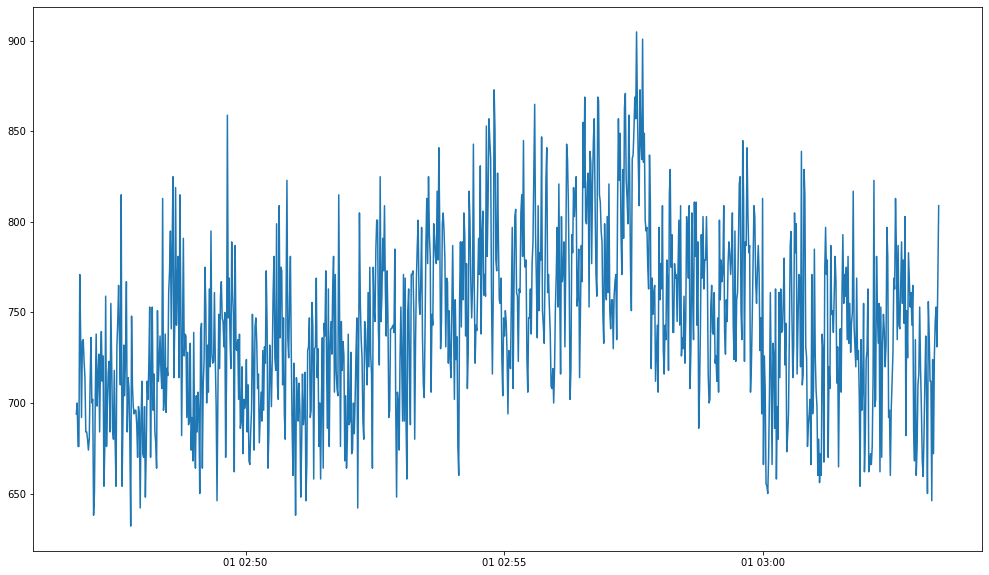

In [18]:
plt.plot(network[10004:11004].index, prediction[:1000])


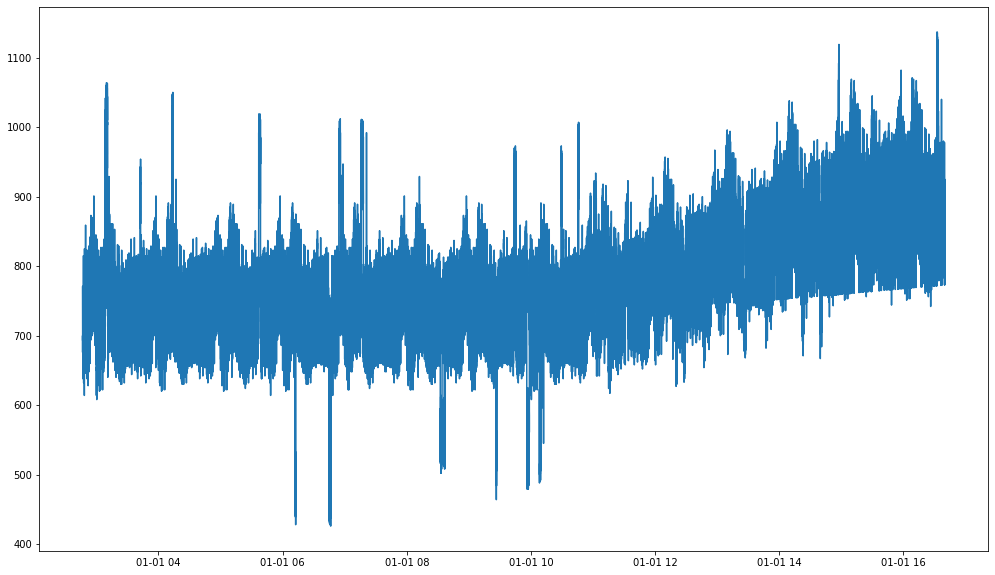

In [23]:
plt.plot(network.index[10004:60004], cleaned)


In [20]:
print(score_for_res(prediction, network[10004:60004]['target']))
print(score_for_res(prediction, cleaned))

0.8180140309532193
0.8251665095128166


In [21]:
'''
test_sum = ntw_clean.sum()
test_num = ntw_clean.size
yt = 0

print(test_sum)

for i in range(0, 10000) :
    yp = yt
    if (i == 0) : 
        yp = None
    
    yt = network[10004+i:10004+i+1]['target']
    xt['prev1'] = network[10001+i:10001+i+1]['target']
    xt['prev2'] = network[10002+i:10002+i+1]['target']
    xt['prev3'] = network[10003+i:10003+i+1]['target']

    #train의 index가 9999에서 끝났으니까, 10000부터 시작
    index = i+10000
    
    if index > 10050 :
        print(index, z, yt)
        yt = test_sum/test_num
        print(index, z, yt)
        
    y_pred, y_std = partial_train(mfr, xt.values.reshape(1, -1), yt)
    #과거 3개만 저장
    np.roll(xt, -1)
    xt[2] = yt
    
    test_sum += yt.values
    test_num += 1
    print(test_sum)
   
    '''

"\ntest_sum = ntw_clean.sum()\ntest_num = ntw_clean.size\nyt = 0\n\nprint(test_sum)\n\nfor i in range(0, 10000) :\n    yp = yt\n    if (i == 0) : \n        yp = None\n    \n    yt = network[10004+i:10004+i+1]['target']\n    xt['prev1'] = network[10001+i:10001+i+1]['target']\n    xt['prev2'] = network[10002+i:10002+i+1]['target']\n    xt['prev3'] = network[10003+i:10003+i+1]['target']\n\n    #train의 index가 9999에서 끝났으니까, 10000부터 시작\n    index = i+10000\n    \n    if index > 10050 :\n        print(index, z, yt)\n        yt = test_sum/test_num\n        print(index, z, yt)\n        \n    y_pred, y_std = partial_train(mfr, xt.values.reshape(1, -1), yt)\n    #과거 3개만 저장\n    np.roll(xt, -1)\n    xt[2] = yt\n    \n    test_sum += yt.values\n    test_num += 1\n    print(test_sum)\n   \n    "